In [192]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re

In [193]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [194]:
spike_collection_json_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\spike_collection.json\spike_collection.json'

In [195]:
import importlib
import spike.spike_analysis.spike_collection as sc

importlib.reload(sc)

<module 'spike.spike_analysis.spike_collection' from 'c:\\Users\\thoma\\Code\\ResearchCode\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\spike_collection.py'>

In [196]:
sp = sc.SpikeCollection.load_collection(spike_collection_json_path)

In [208]:
rec_events = sp.recordings[0].event_dict

# get unique event names from rec_events dictionary
event_names = list(rec_events.keys())
print("Unique event names:", event_names)

Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


### Make sure it's in timestamps not ms

In [197]:
# Pick any one recording and unit
recording = sp.recordings[0]  # or choose a specific one
unit_id = list(recording.unit_timestamps.keys())[0]  # get the first available good unit

# Extract the raw spike timestamps
raw_spikes = recording.unit_timestamps[unit_id]

# Show the first few spikes
print(f"Raw spike timestamps for unit {unit_id}:")
print(raw_spikes[:10])

# Convert to milliseconds
converted_spikes_ms = raw_spikes * (1000 / recording.sampling_rate)
print("\nConverted to milliseconds:")
print(converted_spikes_ms[:10])

# Also print min/max to check range
print(f"\nMin raw spike: {raw_spikes.min()} | Max raw spike: {raw_spikes.max()}")
print(f"Min spike time in ms: {converted_spikes_ms.min():.2f} ms | Max: {converted_spikes_ms.max():.2f} ms")


Raw spike timestamps for unit 104:
[276153 503505 649539 686660 752824 757488 768359 782699 783787 820039]

Converted to milliseconds:
[13807.65 25175.25 32476.95 34333.   37641.2  37874.4  38417.95 39134.95
 39189.35 41001.95]

Min raw spike: 276153 | Max raw spike: 68111594
Min spike time in ms: 13807.65 ms | Max: 3405579.70 ms


In [198]:
def quick_unit_event_firing_rates(recording, event, event_length, pre_window=0, post_window=0):
    """
    Quickly computes spike counts per unit for each event window.
    Returns a dict: {unit_id: [counts per event]}
    """
    event_windows = recording.event_dict[event]
    result = {}
    for unit_id, spikes in recording.unit_timestamps.items():
        if recording.labels_dict.get(unit_id) != "good":
            continue
        counts = []
        for window in event_windows:
            start = (window[0] - pre_window * 1000) / 1000  # convert ms to s
            end = (window[0] + event_length * 1000 + post_window * 1000) / 1000
            count = ((spikes >= start) & (spikes < end)).sum()
            counts.append(count)
        result[unit_id] = np.array(counts)

    # print result
    result_df = pd.DataFrame(result)
    result_df.index = [f"{event}_{i}" for i in range(len(event_windows))]
    print(f"\n\nFiring rates for {event} events:\n\n")
    print(result_df)
    
    return result

In [199]:
def run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=False):
    """
    For each 'good' unit, computes spike counts in event and pre-event baseline windows (in ms),
    runs z-scoring, and returns a DataFrame of results.

    Parameters:
    - recording: SpikeRecording object containing unit timestamps and event windows.
    - event_name: Name of the event to analyze (must be in recording.event_dict).
    - duration: Duration of the event window in seconds.
    - pre_window: Duration of the pre-event baseline window in seconds.
    - SD: Number of standard deviations for significance threshold in z-scoring.
    - verbose: If True, print debugging information.
    Returns:
    - A DataFrame with z-scored firing rates for each unit and event window.
    """
    event_windows = recording.event_dict[event_name]  # event dict values for the event time windows
    event_firing = {}
    baseline_firing = {}

    # Use .good_units if available, otherwise fallback to your original logic
    units = getattr(recording, "good_units", None)
    if units is None:
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]
        if verbose:
            print(f"\nConverting spikes for unit: {unit_id}\n")

        # Convert spike timestamps to milliseconds if needed
        spikes_ms = spikes * (1000 / recording.sampling_rate)

        event_counts = []
        baseline_counts = []
        for window in event_windows:
            start_event = window[0]
            end_event = window[1]

            if verbose:
                print(f"\nEvent window: {start_event}, {end_event} for unit {unit_id}\n")

            start_baseline = start_event - int(pre_window * 1000)
            end_baseline = start_event

            # Count spikes in each window
            event_count = np.sum((spikes_ms >= start_event) & (spikes_ms < end_event))
            baseline_count = np.sum((spikes_ms >= start_baseline) & (spikes_ms < end_baseline))

            event_counts.append(event_count)
            baseline_counts.append(baseline_count)

        if len(event_counts) == len(event_windows) and len(baseline_counts) == len(event_windows):
            event_firing[unit_id] = np.array(event_counts)
            baseline_firing[unit_id] = np.array(baseline_counts)

            if verbose:
                print(f"\nUnit {unit_id} - Event counts: {event_counts}, Baseline counts: {baseline_counts}\n")
        else:
            if verbose:
                print(f"\n\n---Skipping unit {unit_id} due to mismatched counts: {len(event_counts)} vs {len(event_windows)}---\n")

    # Filter out empty entries
    event_firing = {k: v for k, v in event_firing.items() if v.shape and v.shape[0] > 0}
    baseline_firing = {k: v for k, v in baseline_firing.items() if v.shape and v.shape[0] > 0}

    if verbose:
        print(f"\nevent_firing units: {len(event_firing)}")
        print(f"baseline_firing units: {len(baseline_firing)}\n")

    if not event_firing or not baseline_firing:
        if verbose:
            print("\n------------------------------------\nERROR: No valid units for z-scoring because of empty firing rates for all units.\n-------------------------------\n")
        return pd.DataFrame()

    # --- REPLACED RESULT-BUILDING SECTION ---
    rows = []

    for unit in event_firing:
        event_vals = event_firing[unit]
        baseline_vals = baseline_firing[unit]

        ev_mean = np.mean(event_vals)
        baseline_mean = np.mean(baseline_vals)
        baseline_sd = np.std(baseline_vals)

        if baseline_sd == 0:
            zscore = np.nan
        else:
            zscore = (ev_mean - baseline_mean) / baseline_sd

        sig = "not sig"
        if not np.isnan(zscore):
            if zscore > SD:
                sig = "increase"
            elif zscore < -SD:
                sig = "decrease"

        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit,
            "Pre-event M": baseline_mean,
            "Pre-event SD": baseline_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "sig": sig
        })

    df = pd.DataFrame(rows)
    return df


In [200]:
rec = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

df = run_zscore_per_event(rec, event_name, pre_window=10, SD=1.65)
df.head(20)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


In [201]:
recording = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

zscore_df = run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=True)
zscore_df.head(20)



Converting spikes for unit: 104


Event window: 1849109.9, 1859109.9 for unit 104


Event window: 1909109.85, 1919109.95 for unit 104


Event window: 1964109.8, 1974109.9 for unit 104


Event window: 2029109.75, 2039109.75 for unit 104


Event window: 2084109.85, 2094109.7 for unit 104


Event window: 2134109.8, 2144109.7 for unit 104


Event window: 2184109.75, 2194109.75 for unit 104


Event window: 2289109.55, 2299109.65 for unit 104


Event window: 2409109.6, 2419109.6 for unit 104


Event window: 2529109.4, 2539109.4 for unit 104


Event window: 2639109.3, 2649109.3 for unit 104


Event window: 2724109.35, 2734109.35 for unit 104


Event window: 2844109.3, 2854109.15 for unit 104


Event window: 2904109.1, 2914109.1 for unit 104


Event window: 2969109.05, 2979109.15 for unit 104


Event window: 3029109.15, 3039109.0 for unit 104


Event window: 3104108.95, 3114109.1 for unit 104


Event window: 3204108.9, 3214109.0 for unit 104


Event window: 3299108.95, 3309108.8 for unit 104


,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


In [202]:
# loop through all recordings for 'alone_rewarded' event
all_zscore_dfs = []
for recording in sp.recordings:
    if 'alone_rewarded' in recording.event_dict:
        zscore_df = run_zscore_per_event(recording, 'alone_rewarded', pre_window=10, SD=1.65, verbose=False)
        if not zscore_df.empty:
            all_zscore_dfs.append(zscore_df)
# Combine all DataFrames into one
if all_zscore_dfs:
    combined_zscore_df = pd.concat(all_zscore_dfs, ignore_index=True)
    print("\nCombined Z-Score DataFrame for 'alone_rewarded' event:\n")
    print(combined_zscore_df.head(20))
else:
    print("\nNo valid z-score data found for 'alone_rewarded' event across recordings.\n")


Combined Z-Score DataFrame for 'alone_rewarded' event:

                                                                      Recording  \
0   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
2   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
3   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
4   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
5   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
6   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
7   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
8   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
9   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
10  20230612_101430_standard_c

In [203]:
combined_zscore_df.head(40)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


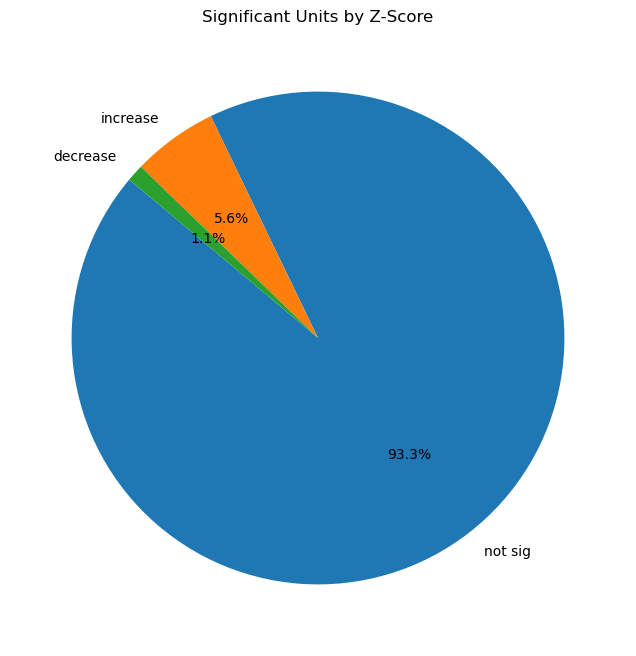

In [204]:
# create pie chart of significant units
def plot_significant_units(df):
    """
    Plots a pie chart of significant units based on z-scores.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Count occurrences of each significance level
    sig_counts = df['sig'].value_counts()

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sig_counts, labels=sig_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Significant Units by Z-Score')
    plt.show()
# Plot significant units for the combined DataFrame
plot_significant_units(combined_zscore_df)

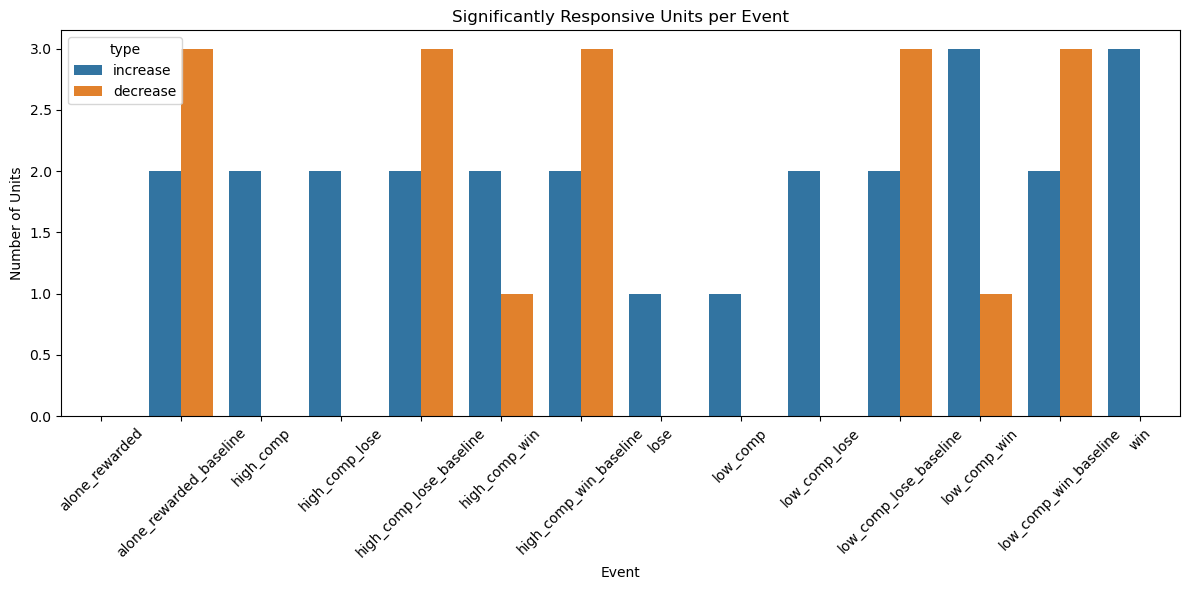

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all z-scored DataFrames across events
event_names = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']

summary_rows = []

for event in event_names:
    zscore_df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65)
    if not zscore_df.empty:
        inc = (zscore_df["sig"] == "increase").sum()
        dec = (zscore_df["sig"] == "decrease").sum()
        summary_rows.append({'event': event, 'type': 'increase', 'count': inc})
        summary_rows.append({'event': event, 'type': 'decrease', 'count': dec})

summary_df = pd.DataFrame(summary_rows)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='event', y='count', hue='type')
plt.xticks(rotation=45)
plt.title('Significantly Responsive Units per Event')
plt.ylabel('Number of Units')
plt.xlabel('Event')
plt.tight_layout()
plt.show()


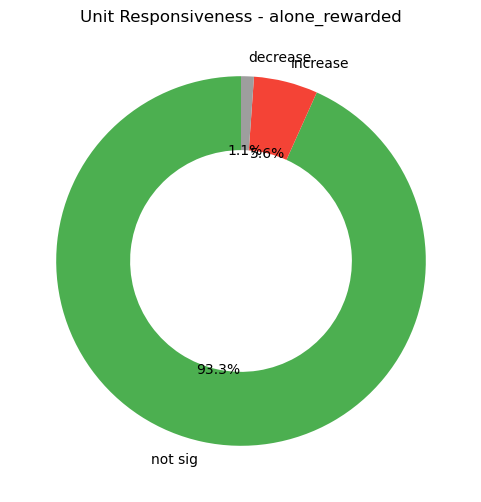

In [211]:
def plot_donut_pie(event_df, event_name):
    counts = event_df['sig'].value_counts()
    labels = counts.index
    sizes = counts.values
    colors = ['#4caf50', '#f44336', '#9e9e9e']  # green, red, gray

    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                      colors=colors[:len(labels)],
                                      startangle=90, wedgeprops=dict(width=0.4))

    ax.set_title(f"Unit Responsiveness - {event_name}")
    plt.show()

# Example usage:
plot_donut_pie(combined_zscore_df, 'alone_rewarded')


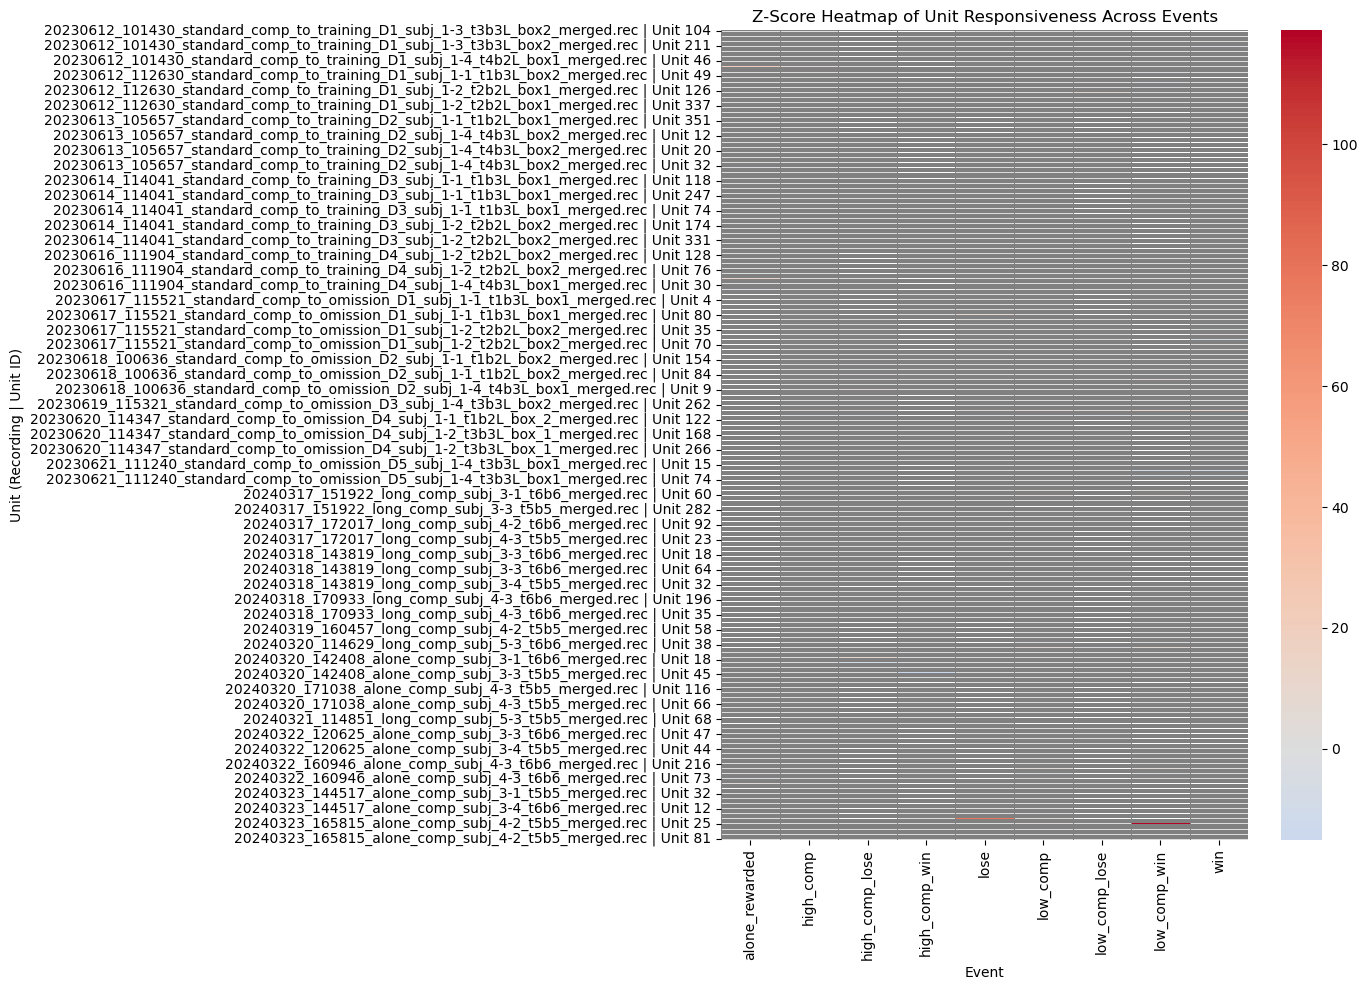

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of events to analyze (excluding baseline/tone-prep events)
event_list = [
    'alone_rewarded', 'high_comp', 'high_comp_lose', 'high_comp_win', 'lose',
    'low_comp', 'low_comp_lose', 'low_comp_win', 'win', 'no_comp_win', 'no_comp_lose'
]

# Collect z-scores across events
zscore_dfs = []

for event in event_list:
    for recording in sp.recordings:
        if event in recording.event_dict:
            df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65, verbose=False)
            if not df.empty:
                zscore_dfs.append(df)

# Combine all into one long DataFrame
all_zscores = pd.concat(zscore_dfs, ignore_index=True)

# Create a unique unit label (Recording + Unit) to distinguish across sessions
all_zscores['Unique Unit'] = all_zscores['Recording'] + ' | Unit ' + all_zscores['Unit number'].astype(str)

# Pivot to get units as rows, events as columns
pivot_df = all_zscores.pivot(index='Unique Unit', columns='Event name', values='Event Z-Score')

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')
plt.title("Z-Score Heatmap of Unit Responsiveness Across Events")
plt.xlabel("Event")
plt.ylabel("Unit (Recording | Unit ID)")
plt.tight_layout()
plt.show()
